In [244]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2 
from tqdm import tqdm

# 1 Introduction

### 1.1 Mountain Car Environment

In [245]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

starting_state, _ = env.reset() 
print(f"Starting state: {starting_state}")

done = False
state, _ = env.reset()
episode_reward = 0
while not done:
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)

    episode_reward += reward

    state = next_state
    done = terminated or truncated

print(f"Episode reward after taking random actions: {episode_reward}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Number of actions available: 3
Observation shape: (2,)
Starting state: [-0.5236993  0.       ]
Episode reward after taking random actions: -200.0


### 1.2 Agents

In [246]:
class Agents():
    def __init__(self, env):
        self.done = False
        self.env = env

    def observe(self, action, next_state, reward):
        None 
    
    def select_action(self, state):
        None

    def update(self):
        None

# 2. First steps

In [247]:
class RandomAgent(Agents):
    def __init__(self, env):
        super().__init__(env)
    
    def select_action(self, state):
        return self.env.action_space.sample()

In [248]:
def episode(env, agent):
    state, _ = env.reset()
    done = False

    episode_reward = 0
    episode_length = 0
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        episode_reward += reward
        episode_length += 1

        state = next_state
        done = terminated or truncated

    return episode_reward, episode_length

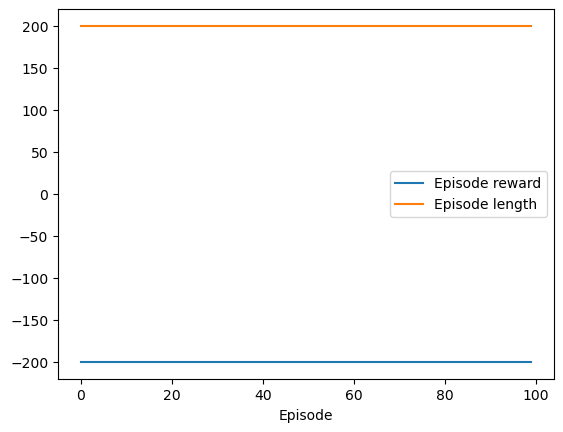

In [249]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = RandomAgent(environment)

num_episodes = 100
episode_rewards = np.empty(num_episodes)
episode_lengths = np.empty(num_episodes)
for i in range(num_episodes):
    episode_rewards[i], episode_lengths[i] = episode(environment, agent)

plt.figure()
plt.plot(episode_rewards, label="Episode reward")
plt.plot(episode_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()

Episode rewaard and episode lentgh are always -200 and 200, which is the default value for truncated=True. 

Basically, random sample of actions never solves the problem. 

# 3. DQN

### 3.1 Implementation 

In [250]:
class Q(torch.nn.Module): 
    def __init__(self):
        super(Q, self).__init__()
        
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3))

    def forward(self, s):
        Q_values = self.MLP(s)
        return Q_values

In [251]:
class ReplayBuffer:    
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.num_samples = 0
        self.buffer = torch.zeros((self.capacity, 6))
        
    def add_observation(self, observation):
        #observation = (state, action, reward, next_state)
        index = self.num_samples % self.capacity

        self.buffer[index] = observation
        self.num_samples += 1

    def sample_batch(self,batch_size=64):
        record_range = min(self.num_samples, self.capacity)
        indices = torch.randint(0,record_range,size=(batch_size,))
        return self.buffer[indices]

In [252]:
class DQNAgent(Agents):
    def __init__(self,env, epsilon = 0.5, batch_size=64):
        super().__init__(env)
        self.Q = Q()
        self.discount_factor = 0.99
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.optimizer = torch.optim.AdamW(self.Q.parameters(), lr=1e-3)
        self.replay_buffer = ReplayBuffer()

    def observe(self, state, action, reward, next_state):
        self.replay_buffer.add_observation(torch.tensor([state[0], state[1], action, reward, next_state[0], next_state[1]], dtype=torch.float32))

    def select_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.Q(torch.tensor(state, dtype=torch.float32)).numpy()
            max_indices = np.argwhere(q == q.max())
            return np.random.choice(max_indices[0])
    
    def update(self):
        #batch.shape = (B, (S_x, S_v, A, R, S'_x, S'_v))
        batch = self.replay_buffer.sample_batch(self.batch_size)
        self.optimizer.zero_grad()

        batch_next_state_Q_values = self.Q(batch[:, 4:]).clone().detach() # shape = (B, 3) 3 is action space
        batch_max_next_state_Q_value = torch.max(batch_next_state_Q_values, dim=1).values
        
        loss = 0.5 * torch.mean((batch[:, 3] + self.discount_factor*batch_max_next_state_Q_value 
                      - self.Q(batch[:, :2])[:, batch[:, 2].int()])**2)
        
        loss.backward()
        self.optimizer.step()
        return loss.item()    

In [253]:
def run_episode_DQN(agent, render=False, video_path="video.mp4"):

    state, _ = environment.reset()
    done = False
    
    episode_reward = 0
    episode_length = 0
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action)
        agent.observe(state, action, reward, next_state)
        agent.update()
        
        
        episode_reward += reward
        episode_length += 1
        state = next_state
        done = terminated or truncated
    if render:
        out.release()
    return episode_reward, episode_length

100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


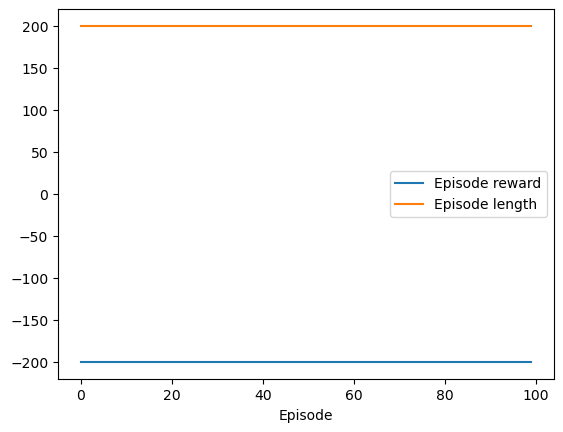

In [254]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
for episode in tqdm(range(1000)):
    if (episode==300): kwargs = dict(render=True, video_path="video_dqn.mp4")
    else: kwargs = dict(render=False)

    total_reward, duration = run_episode_DQN(agent=agent, **kwargs)
    list_rewards.append(total_reward)
    list_lengths.append(duration)

plt.figure()
plt.plot(episode_rewards, label="Episode reward")
plt.plot(episode_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()